In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz 
from IPython import display
from IPython.display import Image
import pydotplus
from sklearn.dummy import DummyClassifier
from patsy import dmatrices, build_design_matrices, dmatrix

%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

pd.set_option('display.float_format', lambda x: '%.2f' % x)

step - Maps a unit of time in the real world. In this case 1 step is 1 hour of time.  
type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER  
- CASH-IN
    - 
- CASH-OUT
- DEBIT
- PAYMENT
- TRANSFER  
  
amount - amount of the transaction in local currency  
  
nameOrig - customer who started the transaction  
  
oldbalanceOrg - initial balance before the transaction  
  
newbalanceOrig - customer's balance after the transaction.  
  
nameDest - recipient ID of the transaction.  
  
oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).  
  
newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).  
  
isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.  
  
isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.  

In [2]:
# Image("/Users/randy/Downloads/Screen Shot 2019-04-26 at 10.32.16 AM.png", width='200')

When comparing Machine Fraud to Actual Fraud:
  
| Category | Machine  | Actual |
| --- | --- | --- |
| True Positive | Fraud | Fraud |
| False Positive | Fraud | Not Fraud |
| True Negative | Not Fraud | Not Fraud |
| False Negative | Not Fraud | Fraud |

In [3]:
data = pd.read_csv('/Users/randy/Downloads/PaySim_Synthetic_Dataset-Fraud.csv')

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [5]:
#I want to change all of the column names to something cleaner
df = data.rename(columns = {'step':'HoursPassed',
                          'type':'TransactionType',
                          'amount':'Amount',
                          'nameOrig':'OriginatorID',
                          'oldbalanceOrg':'OldBalORIG',
                          'newbalanceOrig':'NewBalORIG', 
                          'nameDest':'RecipientID',
                          'oldbalanceDest':'OldBalRCPT', 
                          'newbalanceDest':'NewBalRCPT', 
                          'isFraud':'Fraud',
                          'isFlaggedFraud':'FlaggedFraud'
                         })

In [6]:
#use the pandas_profiling tool to get a summary of all the data
df.describe()

# pandas_profiling.ProfileReport(df)

,HoursPassed,Amount,OldBalORIG,NewBalORIG,OldBalRCPT,NewBalRCPT,Fraud,FlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


# Initial Findings and Thoughts:

- Transfers and Cash_Out are related in many transactions. Ex. fraudsters transfer funds then cash out fast.
- In the IDs, C = Customer, M = Merchant
    - There are no Originator IDs that match Recipient IDs
    - Maybe do one-hot-encoding for C and M
- Do one-hot-encoding for Transaction Type (drop_first = True)
- One-hot-encoding (pd.get_dummies(my_series, drop_first=True)
- Feature engineering - add ratio of transaction amount to old bal
    - Ex. (ORIG) Old Bal > New Bal = negative delta
    - Ex. (RCPT) Old Bal < New Bal = positive delta
    
- Given that our data is extremely one-sided (imbalanced classification problem) The metric our intuition tells us we should maximize is known in statistics as recall, or the ability of a model to find all the relevant cases within a dataset.  
    - Not Fraud represents the overwhelming majority of the data points
    - I could have an extremely high accuracy by just saying "all are not fraud" but the recall would be terrible.

In [7]:
#no matching Originator IDs to the Recipient IDs. I assumed this means the originator is not 
df['OriginatorID'].equals(df['RecipientID'])

False

In [8]:
df.tail()

,HoursPassed,TransactionType,Amount,OriginatorID,OldBalORIG,NewBalORIG,RecipientID,OldBalRCPT,NewBalRCPT,Fraud,FlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.00,C873221189,6510099.11,7360101.63,1,0


In [9]:
#create dummies for transaction types
df_trans = pd.get_dummies(df['TransactionType'],drop_first=True)
df1 = df
frames = [df1,df_trans]
result = pd.concat(frames,axis=1)

#drop the original transaction types
result = result.drop(columns=['TransactionType'])

In [10]:
#remove all numbers in Originator ID and Recipient ID
result['OriginatorID'] = result['OriginatorID'].str.replace('\d+', '')
result['RecipientID'] = result['RecipientID'].str.replace('\d+', '')

#removing all the numbers in Originator ID leaves only 'C' so I drop the whole column
result = result.drop(columns = ['OriginatorID'])

#do a get_dummies for Recipient ID since there are Merchants ('M') and Customers ('C')
result_recip = pd.get_dummies(result['RecipientID'],drop_first=True)
result1 = result
frames = [result1,result_recip]
new_result = pd.concat(frames,axis=1)

new_result = new_result.drop(columns = ['RecipientID'])


In [11]:
#ok, all of the variables are now either binary or some other numerical value
# new_result.info()
# new_result_tail.describe()
new_result['isFraud'] = new_result['Fraud']
new_result = new_result.drop(columns = ['Fraud'])

In [12]:
#create new columns for difference in Originator ID and Recipient ID
new_result.insert(2, 'ChangeORIG', (new_result['NewBalORIG']-new_result['OldBalORIG']))
new_result.insert(4, 'ChangeRCPT', (new_result['NewBalRCPT']-new_result['OldBalRCPT']))

#drop original ORIG and RCPT transactions
final_result = new_result.drop(columns = ['OldBalORIG','NewBalORIG','OldBalRCPT','NewBalRCPT','Amount'])
#,'TRANSFER','M','PAYMENT','HoursPassed', 'FlaggedFraud'

In [13]:
final_result = final_result.drop(columns = ['HoursPassed'])

In [14]:
len(final_result)

6362620

In [15]:
result_df = final_result.drop_duplicates(['ChangeORIG'],keep='first')

In [19]:
len(result_df)

2962285

In [20]:
no_fraud_result = result_df.drop(columns=['isFraud'])

ratio of Fraud to NotFraud:  0.0012924888191769902
0    2958463
1       3822
Name: isFraud, dtype: int64


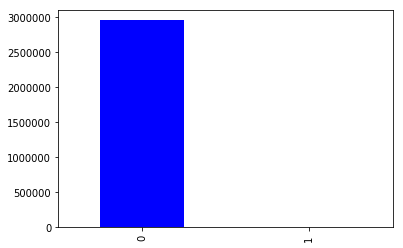

In [21]:
# data.info()
#EDA and Baselining
target_pcts = result_df.isFraud.value_counts(normalize=False) 
print('ratio of Fraud to NotFraud: ', 8213/6354407)
print(target_pcts)

target_pcts.plot(kind='bar', color='blue');

In [22]:
X_break, X_test, y_break, y_test = train_test_split(no_fraud_result, result_df['isFraud'], \
                                                    test_size=0.2, stratify=result_df['isFraud'],
                                                    random_state=12345)
#random_state generates a set kind of deck for each random state. 41 will always be the same kind of split

X_train, X_val, y_train, y_val = train_test_split(X_break, y_break, \
                                                    test_size=0.25, stratify=y_break,
                                                    random_state=12345)

In [ ]:
no_fra

In [ ]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
final_result.head()

In [ ]:
# # Run CV with 5 folds (knn)

# ks = [501]
# param_grid = [{'n_neighbors': ks}]

# knn = KNeighborsClassifier()
# knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
# knn_grid.fit(x_norm_train, y_train)

In [23]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud']);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [24]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training set: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Validation set: {:6.2f}%".format(100*logit.score(X_val, y_val)))

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score for logistic regression is
Training set:  99.92%
Validation set:  99.92%


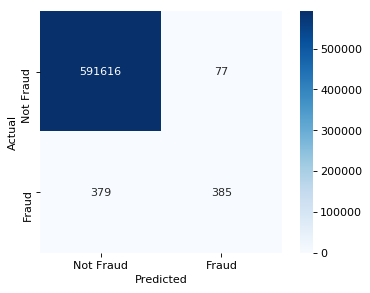

In [25]:
#base, threshold 0.5
make_confusion_matrix(logit)


In [26]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [27]:
# using the new threshold of n
def check_threshold(n):
    y_predict = (logit.predict_proba(X_val)[:,1] > float(n))
    print(f'Threshold of {n}:')
    print('Precision: {:6.4f},   Recall: {:6.4f}'.format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))
    print(f'Total Score: {precision_score(y_val, y_predict) + recall_score(y_val, y_predict)}')
    print('')

In [28]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = logit.predict(X_val)
print("Default threshold: 0.5")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_predict), 
                                                     recall_score(y_val, y_predict)))

Default threshold: 0.5
Precision: 0.8333,   Recall: 0.5039


In [29]:
for threshhold in np.arange(0.0, 1.0, 0.02):
    check_threshold(threshhold)
    #threshold of 0.52 holds the highest Total Score at 1.44


Threshold of 0.0:
Precision: 0.0013,   Recall: 1.0000
Total Score: 1.00128954506403

Threshold of 0.02:
Precision: 0.1856,   Recall: 0.7618
Total Score: 0.9473668394059195

Threshold of 0.04:
Precision: 0.3286,   Recall: 0.6950
Total Score: 1.0236152869213622

Threshold of 0.06:
Precision: 0.4252,   Recall: 0.6584
Total Score: 1.083567157771749

Threshold of 0.08:
Precision: 0.4827,   Recall: 0.6217
Total Score: 1.1044513259268718

Threshold of 0.1:
Precision: 0.5439,   Recall: 0.6086
Total Score: 1.1524983925783046

Threshold of 0.12:
Precision: 0.5891,   Recall: 0.5969
Total Score: 1.186005925565161

Threshold of 0.14:
Precision: 0.6183,   Recall: 0.5851
Total Score: 1.203335795442202

Threshold of 0.16:
Precision: 0.6529,   Recall: 0.5785
Total Score: 1.2314143859187825

Threshold of 0.18:
Precision: 0.6776,   Recall: 0.5694
Total Score: 1.246941821206635

Threshold of 0.2:
Precision: 0.6976,   Recall: 0.5615
Total Score: 1.259079300217086

Threshold of 0.22:
Precision: 0.7221,   Re

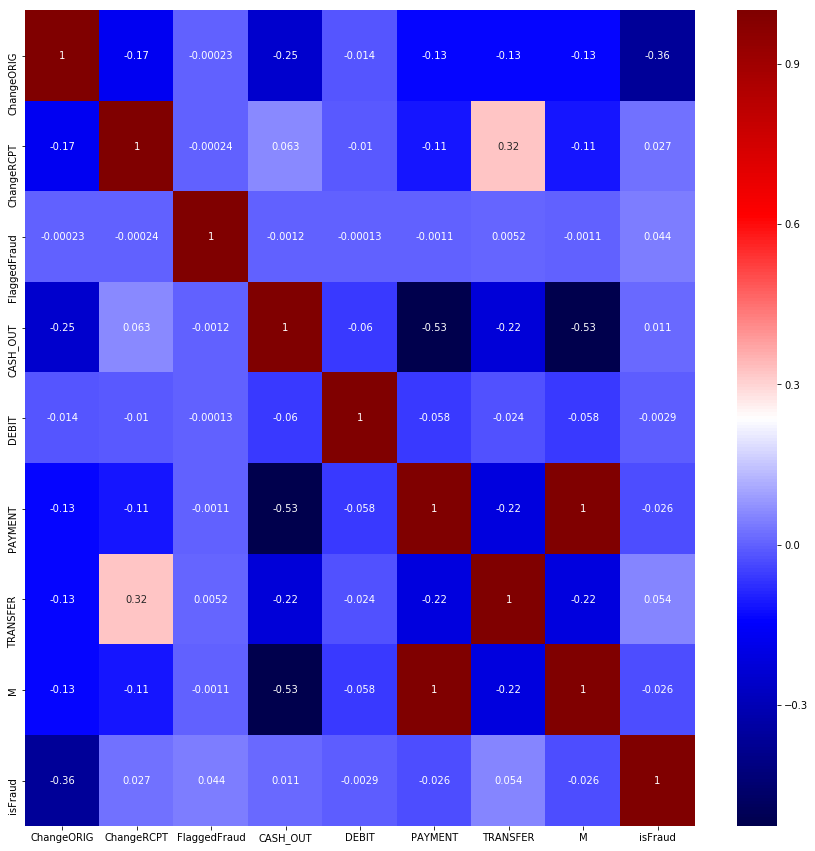

In [30]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(final_result.corr(), cmap="seismic", ax=ax, annot=True)
plt.show()

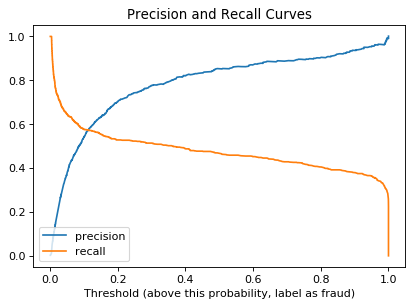

In [31]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logit.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

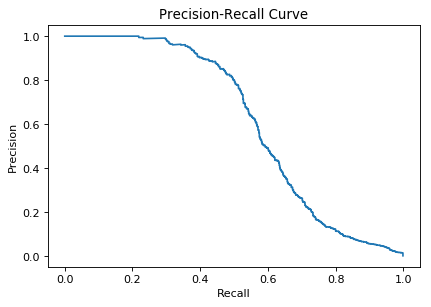

In [32]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

# The ROC Curve

In [33]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

ROC AUC score =  0.9930951904333649


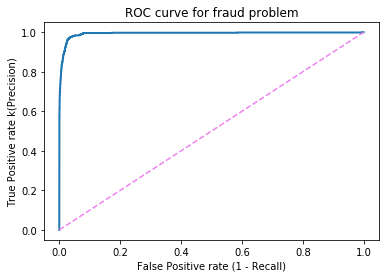

In [34]:
fpr, tpr, thresholds = roc_curve(y_val, logit.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

#Precision = True Positive Rate

plt.xlabel('False Positive rate (1 - Recall)')
plt.ylabel('True Positive rate k(Precision)')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_val, logit.predict_proba(X_val)[:,1]))

In [35]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training set: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Validation set: {:6.2f}%".format(100*logit.score(X_val, y_val)))

/Users/randy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score for logistic regression is
Training set:  99.92%
Validation set:  99.92%


In [36]:
# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
logistic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([    1.     ,     2.78256,     7.74264,    21.54435,    59.94843,
         166.81005,   464.15888,  1291.54967,  3593.81366, 10000.     ]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=30)

In [49]:
# Run CV with 5 folds (SVM). Unsure if I can run this given how long it takes

C = [1]
gammas = [0.001, 0.1,0.5]
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=30, n_jobs=-1)
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   23.9s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   23.9s remaining:   55.7s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   23.9s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   23.9s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   23.9s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   23.9s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:   23.9s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.9s remaining:    0.0s


KeyboardInterrupt: 

In [38]:
# Run CV with 5 folds (Random Forest)

# Number of trees in random forest
n_estimators = [200]#[200, 250] #200 or 250 models. test this more
# Number of features to consider at every split
max_features = ['auto'] #sqrt
# Maximum number of levels in tree
max_depth = [40]#[70, 80]
# Minimum number of samples required to split a node
min_samples_split = [2,5]#[2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4]#[1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth, #how deep the tree gets to go, test this more
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

# #looking for the best hyperparams
# #Create base model to tune
rfc=RandomForestClassifier()
# #GridSearch parameters, using 5 fold cross validation
# rf_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=2, verbose=10, n_jobs=-1)
# #Fit the GridSearch model
# rf_grid.fit(X_train, y_train)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=2, verbose=50, n_jobs=-1)
CV_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.1min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  2.1min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  2.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  2.4min remaining:   48.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.5min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [40], 'min_samples_split': [2, 5], 'min_samples_leaf': [2, 4], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=50)

In [37]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(X_train, y_train)

In [ ]:
# # Fit sub_grade Classifier

# isFraud = 'isFraud'
# x_patsy_sg = dmatrix(isFraud, X_train)
# #x_patsy_sg_test = x_patsy_sg[test_index,:]
# x_patsy_sg_val = x_patsy_sg[y_val,:]
# x_patsy_sg_train = x_patsy_sg[y_train,:]

# logistic_sub_grade = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
# logistic_sub_grade.fit(x_patsy_sg_train, y_train)
# logistic_sub_grade.coef_

In [48]:
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % CV_rfc.best_score_)
CV_rfc.best_estimator_

Best ROC_AUC for logit: 0.9778


NameError: name 'svm_grid' is not defined

In [40]:
print('Best Params for logit: ', logistic_grid.best_params_)
print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', CV_rfc.best_params_)

Best Params for logit:  {'C': 1.0, 'penalty': 'l2'}
Best Params for rf:  {'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [41]:
dc = DummyClassifier()
dc.fit(X_train, y_train)
# print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_val, dc.predict_proba(X_val))))

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [42]:
X_train.head()

,ChangeORIG,ChangeRCPT,FlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,M
869955,232380.07,-232380.07,0,0,0,0,0,0
501838,-57599.38,66964.05,0,1,0,0,0,0
6281307,219213.98,-219213.98,0,0,0,0,0,0
5632612,-10120.49,1789641.14,0,0,0,0,1,0
64916,-2828.00,722328.16,0,1,0,0,0,0


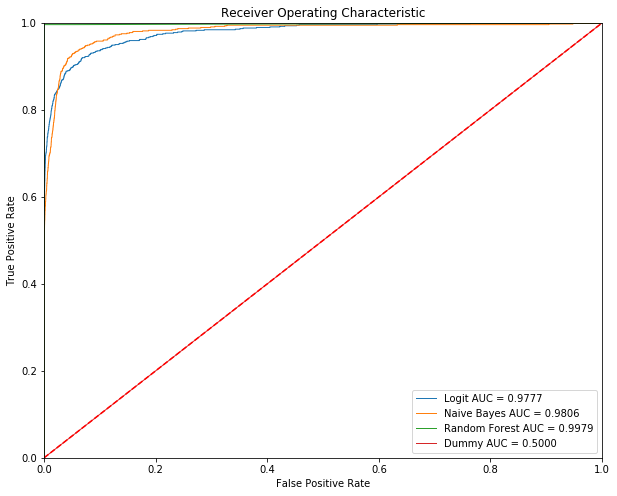

In [45]:
model_list = [logistic_grid.best_estimator_, 
#               svm_grid.best_estimator_, 
              gnb_best,
#               rf_random.best_estimator_
#               knn_grid.best_estimator_,
              CV_rfc.best_estimator_,
             dc]

model_name = ['Logit', 'Naive Bayes', 'Random Forest', 'Dummy']
 
# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    y_pred = list(model.predict_proba(X_val)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc),linewidth=1.0)

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#this lists out the strength of each feature for the random forest
#you'll see that the last column of X_train was used the most, which was 'isFraud'
#I should have removed isFraud column when doing my test_train_split
CV_rfc.best_estimator_.feature_importances_

In [ ]:
X_train.head() 
#top 3 columns: Amount, OldBalORIG, NewBalRCPT

In [46]:
for item1,item2 in zip(X_train.columns,CV_rfc.best_estimator_.feature_importances_):
    print(f'{item1} has a score of {item2}')

ChangeORIG has a score of 0.2803959241308962
ChangeRCPT has a score of 0.6088627661290235
FlaggedFraud has a score of 0.0
CASH_OUT has a score of 0.002200949001078289
DEBIT has a score of 2.4345225117805343e-05
PAYMENT has a score of 0.00027474333911455125
TRANSFER has a score of 0.10762797391654474
M has a score of 0.0006132982582250301


In [ ]:
# Examine the correlation of the model errors

logit_error = y_train - logistic_grid.predict_proba(X_train)[:,1]
gnb_error = y_train - gnb_best.predict_proba(X_train)[:,1]
rf_error = y_train - CV_rfc.predict_proba(X_train)[:,1]

error_df = pd.DataFrame()
error_df['logit'] = logit_error
error_df['gnb'] = gnb_error
error_df['rand_forest'] = rf_error

error_df.corr()

In [ ]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Fraud") 

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=merp,  
                      class_names=['NotFraud','isFraud'], 
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
# # No max depth
# model = RandomForestClassifier(max_depth = None, n_estimators=10)
# model.fit(iris.data, iris.target)
# estimator_nonlimited = model.estimators_[5]
# estimator_limited

# export_graphviz(estimator_limited, out_file='tree_limited.dot', feature_names = iris.feature_names,
#                 class_names = iris.target_names,
#                 rounded = True, proportion = False, precision = 2, filled = True)

# # export_graphviz(estimator_nonlimited, out_file='tree_nonlimited.dot', feature_names = iris.feature_names,
# #                 class_names = iris.target_names,
# #                 rounded = True, proportion = False, precision = 2, filled = True)

# Image(filename = 'tree_limited.png')

In [ ]:
merp = []
for item in X_train.columns:
    merp.append(item)

## Log Loss Cross-Entropy

_A more intensive metric for measuring the performance of your models._ So far, everything we've discussed uses "hard-predictions" to determine how well the model is doing. You apply some threshold and decided, "yes, I believe this is class XYZ" before checking to see if it's actually XYZ. 

That's an okay method, but it doesn't really give us a sense of how close the model was to being wrong. E.g., if we have a threshold of `0.5` and a record that's actually class 1, precision, recall, accuracy, etc. all give equal credit to a prediction that got the class correct, whether it was with `p = 0.51` or `p=0.99`. The second is much higher confidence though! 

Similarly, they give equal penalty to `p = 0.49` and `p=0.01`, though we were much more confident (in the wrong direction) in the second case. Guesses around `0.5` shouldn't be penalized as much, because our model is already admitting "hey, I don't really know what this observation is." 

Enter log-loss. For the binary case, we can define log-loss:

$$ LLCE = - \sum_{i=1}^{N} y \cdot log(p_{y}) + (1-y) \cdot log((1-p_{y}))$$

What does this do? It says, "If the class is actually 1, did you predict close to p=1? If not, that's a big penalty. Though, we'll penalize you way more if you predicted close to p=0. If the class is actually 0, did you predict close to p=0? If not, that's another big penalty."

The main take-aways here are:

>- Log-loss allows us to measure not just "did our model get XYZ right?" but "how confident was it in when predicting?"
>
>- A lower log-loss is better

The cost function typically used for Gradient Descent on classification is log-loss-cross-entropy!

In [ ]:
print("Log-loss on logit: {:6.4f}".format(log_loss(y_val, lm.predict_proba(X_val))))

In [ ]:
print("Logistic accuracy: {:6.4f}".format(lm.score(X_val, y_val)))
print("Dummy accuracy: {:6.4f}".format(dc.score(X_val, y_val)))

Classification Model Complexity

Let's Try Patsy!

In [ ]:
def ols_formula(df, dependent_var, *excluded_cols):
   '''
   Returns the "R style" formula for the patsy function given
   the dataframe, target variable and optional excluded columns
   as strings
   '''
   df_columns = list(df.columns.values)
   df_columns.remove(dependent_var)
   for col in excluded_cols:
       df_columns.remove(col)

   return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [ ]:
formula = ols_formula(new_result,'isFraud')